In [4]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from data.synthetic import make_moons_dataset, split_and_standardize
from models.mlp import MLP
from optim.factory import OptimConfig, make_optimizer
from train.trainer import TrainConfig, train_classifier

torch.manual_seed(42)
np.random.seed(42)


In [6]:
device = "cpu"  

X, y = make_moons_dataset(n_samples=4000, noise=0.25, seed=42, device=device)
X_tr, y_tr, X_val, y_val, scaler = split_and_standardize(X, y, test_size=0.2, seed=42)

print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape)


torch.Size([3200, 2]) torch.Size([3200]) torch.Size([800, 2]) torch.Size([800])


In [7]:
def run_once(
    opt_name: str,
    lr: float,
    steps: int = 1500,
    batch_size: int = 256,
    act: str = "relu",
    clip_norm=None,
    seed: int = 42,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = MLP(in_dim=2, hidden_dim=128, out_dim=1, act=act, use_he=True)
    opt_cfg = OptimConfig(name=opt_name, lr=lr, weight_decay=0.0)
    opt = make_optimizer(model.parameters(), opt_cfg)

    cfg = TrainConfig(
        steps=steps,
        batch_size=batch_size,
        log_every=50,
        clip_norm=clip_norm,
        device=device,
    )

    hist = train_classifier(
        model=model,
        optimizer=opt,
        X_train=X_tr,
        y_train=y_tr,
        X_val=X_val,
        y_val=y_val,
        cfg=cfg,
    )
    return hist


In [8]:
lrs_sgd = np.logspace(-4, 0, 9)   # 1e-4 ... 1
lrs_adam = np.logspace(-5, -2, 9) # 1e-5 ... 1e-2


In [9]:
sweep_sgd = {}
for lr in lrs_sgd:
    hist = run_once("sgd", float(lr), steps=1500, act="relu", seed=42)
    sweep_sgd[float(lr)] = hist
    print("SGD lr=", lr, "val.acc(last)=", hist["val.acc"][-1], "val.loss(last)=", hist["val.loss"][-1])


SGD lr= 0.0001 val.acc(last)= 0.8475000262260437 val.loss(last)= 0.5492646098136902
SGD lr= 0.00031622776601683794 val.acc(last)= 0.8575000166893005 val.loss(last)= 0.4293844699859619
SGD lr= 0.001 val.acc(last)= 0.8650000095367432 val.loss(last)= 0.3391716778278351
SGD lr= 0.0031622776601683794 val.acc(last)= 0.8687499761581421 val.loss(last)= 0.3089991509914398
SGD lr= 0.01 val.acc(last)= 0.8762500286102295 val.loss(last)= 0.29172295331954956
SGD lr= 0.03162277660168379 val.acc(last)= 0.9024999737739563 val.loss(last)= 0.23972029983997345
SGD lr= 0.1 val.acc(last)= 0.9424999952316284 val.loss(last)= 0.1609596461057663
SGD lr= 0.31622776601683794 val.acc(last)= 0.9512500166893005 val.loss(last)= 0.14440955221652985
SGD lr= 1.0 val.acc(last)= 0.9487500190734863 val.loss(last)= 0.1438727229833603


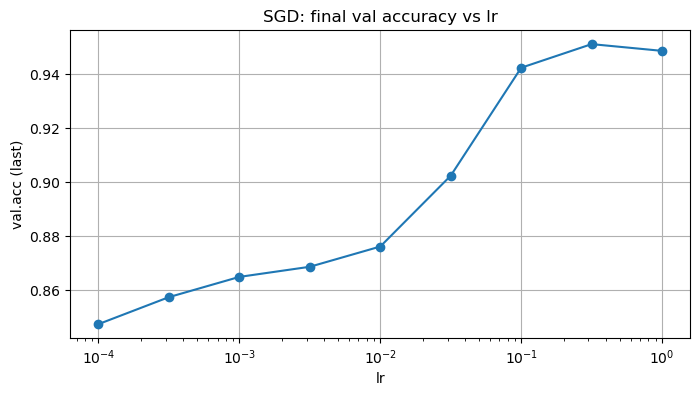

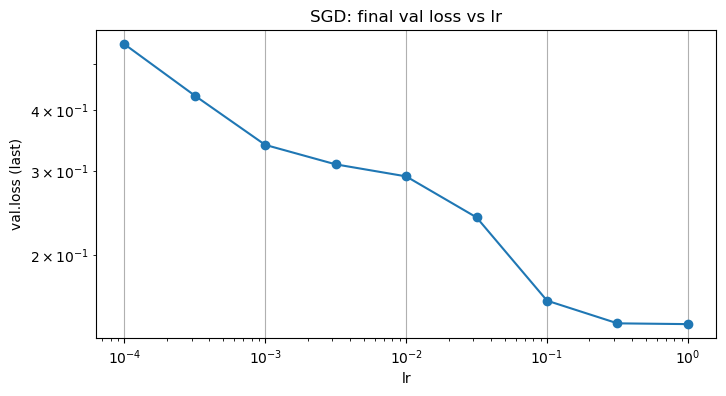

In [10]:
def final_metrics(sweep_dict):
    lrs = sorted(sweep_dict.keys())
    acc = [sweep_dict[lr]["val.acc"][-1] for lr in lrs]
    loss = [sweep_dict[lr]["val.loss"][-1] for lr in lrs]
    return np.array(lrs), np.array(acc), np.array(loss)

lrs, acc, loss = final_metrics(sweep_sgd)

plt.figure(figsize=(8,4))
plt.plot(lrs, acc, marker="o")
plt.xscale("log")
plt.grid(True)
plt.title("SGD: final val accuracy vs lr")
plt.xlabel("lr")
plt.ylabel("val.acc (last)")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(lrs, loss, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.title("SGD: final val loss vs lr")
plt.xlabel("lr")
plt.ylabel("val.loss (last)")
plt.show()


In [11]:
def is_bad(hist):
    # robust check: any nan in logged losses
    arr = np.array(hist["train.loss"], dtype=float)
    return np.any(~np.isfinite(arr))

bad = [lr for lr, h in sweep_sgd.items() if is_bad(h)]
print("Bad lrs (SGD):", bad)


Bad lrs (SGD): []


In [12]:
def pick_best_lr(sweep_dict):
    # best by val.acc last
    best_lr = max(sweep_dict.keys(), key=lambda lr: sweep_dict[lr]["val.acc"][-1])
    return best_lr

best_lr_sgd = pick_best_lr(sweep_sgd)
print("Best SGD lr:", best_lr_sgd)

candidates = sorted(list(set([
    best_lr_sgd,                  # лучший
    best_lr_sgd / 10,             # соседний слева от лучшего
    best_lr_sgd * 10,             # соседний справа от лучшего
    min(sweep_sgd.keys()),        # худший min
    max(sweep_sgd.keys()),        # худший max
])))

candidates = [lr for lr in candidates if lr in sweep_sgd]
print("Candidates:", candidates)


Best SGD lr: 0.31622776601683794
Candidates: [0.0001, 0.03162277660168379, 0.31622776601683794, 1.0]


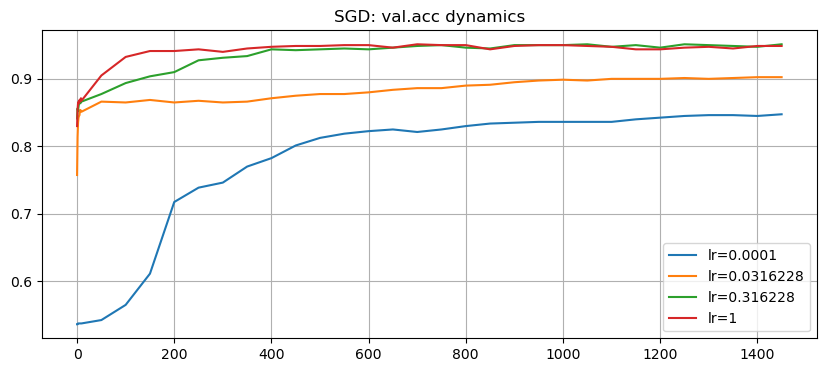

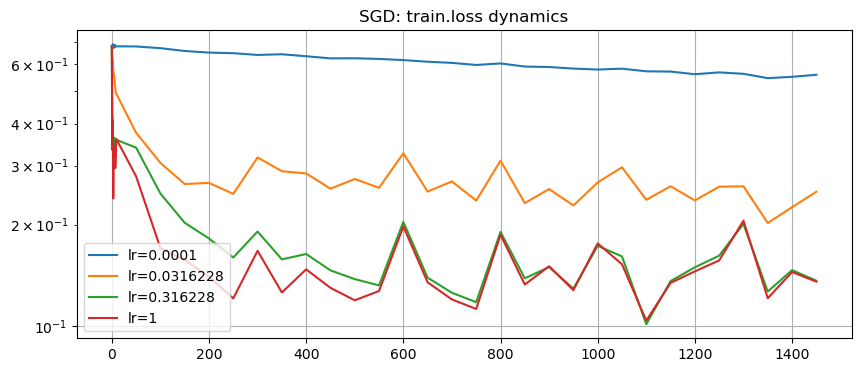

In [13]:
plt.figure(figsize=(10,4))
for lr in candidates:
    h = sweep_sgd[lr]
    plt.plot(h["step"], h["val.acc"], label=f"lr={lr:g}")
plt.xscale("linear")
plt.grid(True)
plt.legend()
plt.title("SGD: val.acc dynamics")
plt.show()

plt.figure(figsize=(10,4))
for lr in candidates:
    h = sweep_sgd[lr]
    plt.plot(h["step"], h["train.loss"], label=f"lr={lr:g}")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.title("SGD: train.loss dynamics")
plt.show()


In [14]:
sweep_adam = {}
for lr in lrs_adam:
    hist = run_once("adam", float(lr), steps=1500, act="relu", seed=42)
    sweep_adam[float(lr)] = hist
    print("Adam lr=", lr, "val.acc(last)=", hist["val.acc"][-1], "val.loss(last)=", hist["val.loss"][-1])


Adam lr= 1e-05 val.acc(last)= 0.8424999713897705 val.loss(last)= 0.54555743932724
Adam lr= 2.3713737056616554e-05 val.acc(last)= 0.8587499856948853 val.loss(last)= 0.4364778995513916
Adam lr= 5.623413251903491e-05 val.acc(last)= 0.8637499809265137 val.loss(last)= 0.3300250172615051
Adam lr= 0.0001333521432163324 val.acc(last)= 0.8812500238418579 val.loss(last)= 0.2781673073768616
Adam lr= 0.00031622776601683794 val.acc(last)= 0.9162499904632568 val.loss(last)= 0.20591683685779572
Adam lr= 0.0007498942093324559 val.acc(last)= 0.9437500238418579 val.loss(last)= 0.15248674154281616
Adam lr= 0.0017782794100389228 val.acc(last)= 0.9474999904632568 val.loss(last)= 0.14647820591926575
Adam lr= 0.004216965034285823 val.acc(last)= 0.9462500214576721 val.loss(last)= 0.146342471241951
Adam lr= 0.01 val.acc(last)= 0.949999988079071 val.loss(last)= 0.15052667260169983


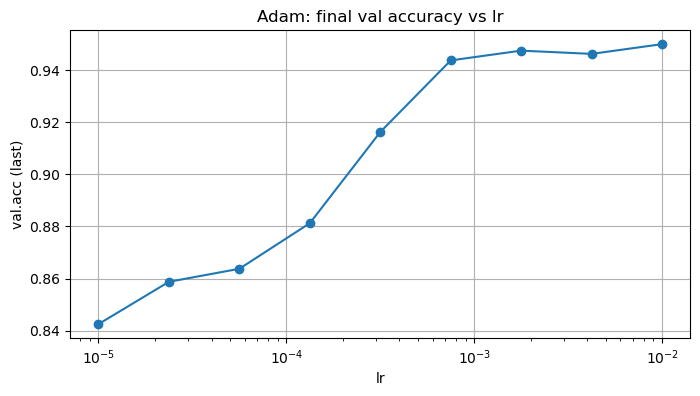

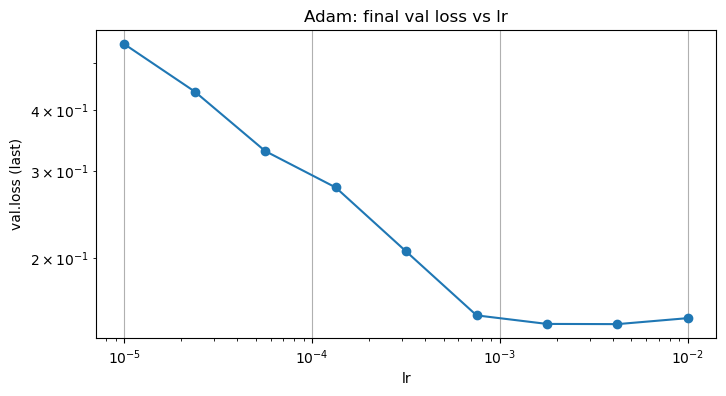

In [15]:
lrs, acc, loss = final_metrics(sweep_adam)

plt.figure(figsize=(8,4))
plt.plot(lrs, acc, marker="o")
plt.xscale("log")
plt.grid(True)
plt.title("Adam: final val accuracy vs lr")
plt.xlabel("lr")
plt.ylabel("val.acc (last)")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(lrs, loss, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.title("Adam: final val loss vs lr")
plt.xlabel("lr")
plt.ylabel("val.loss (last)")
plt.show()


In [16]:
bad = [lr for lr, h in sweep_adam.items() if is_bad(h)]
print("Bad lrs (Adam):", bad)


Bad lrs (Adam): []


In [17]:
best_lr_adam = pick_best_lr(sweep_adam)
print("Best Adam lr:", best_lr_adam)

candidates = sorted(list(set([
    best_lr_adam,
    best_lr_adam / 10,
    best_lr_adam * 10,
    min(sweep_adam.keys()),
    max(sweep_adam.keys()),
])))

candidates = [lr for lr in candidates if lr in sweep_adam]
print("Candidates:", candidates)


Best Adam lr: 0.01
Candidates: [1e-05, 0.01]


Исследование чувствительности к learning rate показало, что SGD сильно зависит от выбора шага обучения и имеет узкую область оптимальных значений (примерно lr ~ 0.1–0.3). При меньших значениях обучение существенно замедляется, а вне оптимального диапазона качество быстро ухудшается.
В отличие от него, Adam демонстрирует устойчивую сходимость и близкие к оптимальным значения validation-метрик на широком диапазоне learning rate (~ от 7e-4 до 1e-2), что подтверждает его способность адаптивно нормализовать эффективный шаг обновления параметров.